  feature        VIF
0    MYCT   1.099378
1    MMIN   5.856803
2    MMAX   7.857060
3    CACH   2.681135
4   CHMIN   2.899712
5   CHMAX   3.138868
6     ERP  10.211842

## 1. Pipeline 기반 다중 회귀 모델링

### 1.1. 최적 하이퍼파라미터 (RandomForestRegressor): {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}

### 1.2. 최적 하이퍼파라미터 (GradientBoostingRegressor): {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}

### 1.3. 평가 지표 (RandomForestRegressor):
|    | Metric   |   Training |   Testing |
|----|----------|------------|-----------|
|  0 | MSE      |   809.6227 | 6856.6184 |
|  1 | MAE      |    11.4330 |   34.3996 |
|  2 | R^2      |     0.9579 |    0.8653 |

### 1.4. 평가 지표 (GradientBoostingRegressor):
|    | Metric   |   Training |   Testing |
|----|----------|------------|-----------|
|  0 | MSE      |   587.1055 | 9181.1077 |
|  1 | MAE      |    16.4626 |   40.4879 |
|  2 | R^2      |     0.9695 |    0.8196 |

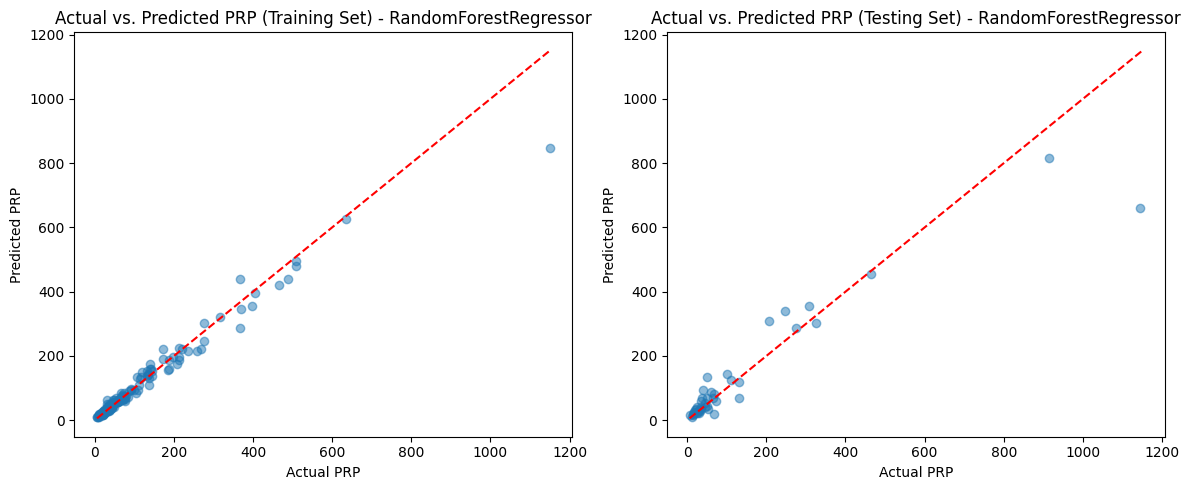

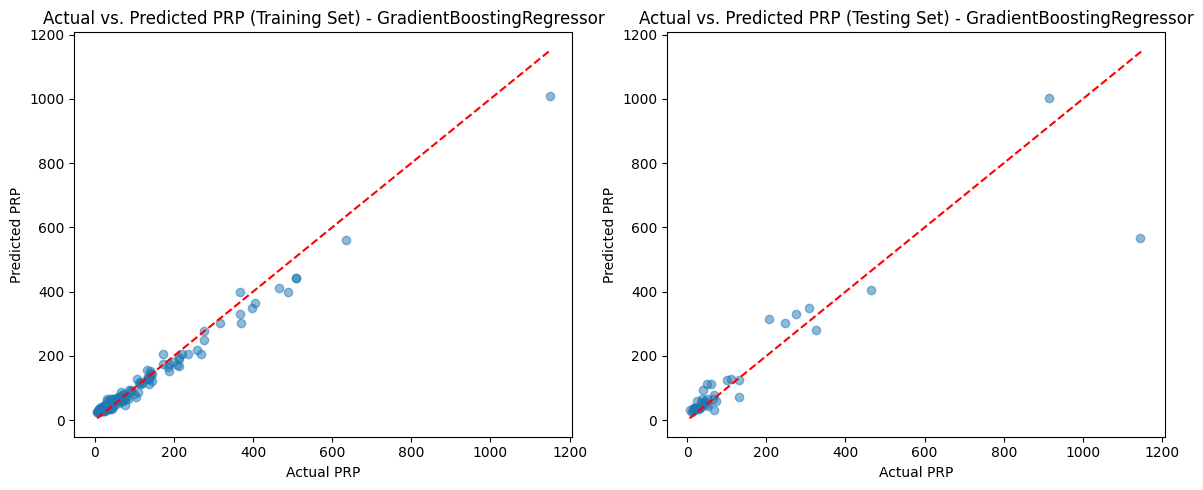


### 1.7. 앙상블 모델 평가 지표:
|    | Metric   |   Training |   Testing |
|----|----------|------------|-----------|
|  0 | MSE      |   601.2041 | 7702.8090 |
|  1 | MAE      |    13.3454 |   34.8897 |
|  2 | R^2      |     0.9687 |    0.8487 |

### 1.8. 앙상블 모델 교차 검증 결과:
Mean R^2: 0.7942
Standard Deviation of R^2: 0.0897


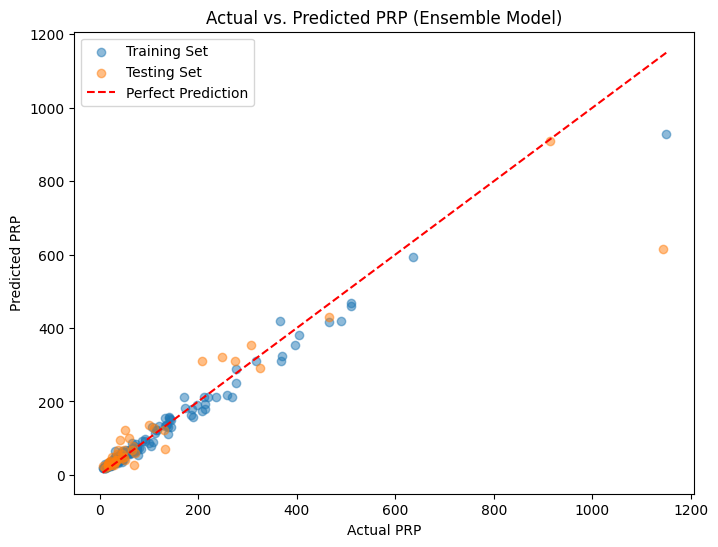

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import VotingRegressor
# 데이터 로드
df = pd.read_csv("machine_data_update.csv")

# 특성 및 타겟 변수 정의
X = df.drop(["VendorName", "ModelName", "PRP"], axis=1)  # 설명 변수
y = df["PRP"]  # 타겟 변수

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중공선성 확인 및 제거
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

# VIF 10 이상인 특성 제거
X_train = X_train.drop(vif_data[vif_data['VIF'] > 10]['feature'], axis=1)
X_test = X_test.drop(vif_data[vif_data['VIF'] > 10]['feature'], axis=1)

# 파이프라인 정의 (RandomForestRegressor)
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('regressor', RandomForestRegressor(random_state=42))  # 랜덤 포레스트 모델
])

# 파이프라인 정의 (GradientBoostingRegressor)
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('regressor', GradientBoostingRegressor(random_state=42))  # 그래디언트 부스팅 모델
])

# 하이퍼파라미터 그리드 설정 (RandomForestRegressor)
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

# 하이퍼파라미터 그리드 설정 (GradientBoostingRegressor)
param_grid_gb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

# 그리드 서치를 통한 최적 모델 탐색 (RandomForestRegressor)
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 그리드 서치를 통한 최적 모델 탐색 (GradientBoostingRegressor)
grid_search_gb = GridSearchCV(pipe_gb, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# 최적 모델 (RandomForestRegressor)
best_model_rf = grid_search_rf.best_estimator_

# 최적 모델 (GradientBoostingRegressor)
best_model_gb = grid_search_gb.best_estimator_

# 훈련 세트 예측 및 평가 (RandomForestRegressor)
y_train_pred_rf = best_model_rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# 테스트 세트 예측 및 평가 (RandomForestRegressor)
y_test_pred_rf = best_model_rf.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# 훈련 세트 예측 및 평가 (GradientBoostingRegressor)
y_train_pred_gb = best_model_gb.predict(X_train)
mse_train_gb = mean_squared_error(y_train, y_train_pred_gb)
mae_train_gb = mean_absolute_error(y_train, y_train_pred_gb)
r2_train_gb = r2_score(y_train, y_train_pred_gb)

# 테스트 세트 예측 및 평가 (GradientBoostingRegressor)
y_test_pred_gb = best_model_gb.predict(X_test)
mse_test_gb = mean_squared_error(y_test, y_test_pred_gb)
mae_test_gb = mean_absolute_error(y_test, y_test_pred_gb)
r2_test_gb = r2_score(y_test, y_test_pred_gb)

# 교차 검증 (RandomForestRegressor)
cv_scores_rf = cross_val_score(best_model_rf, X, y, cv=5, scoring='r2')

# 교차 검증 (GradientBoostingRegressor)
cv_scores_gb = cross_val_score(best_model_gb, X, y, cv=5, scoring='r2')

# 결과 출력
print("\n## 1. Pipeline 기반 다중 회귀 모델링")
print(f"\n### 1.1. 최적 하이퍼파라미터 (RandomForestRegressor): {grid_search_rf.best_params_}")
print(f"\n### 1.2. 최적 하이퍼파라미터 (GradientBoostingRegressor): {grid_search_gb.best_params_}")


# 평가 지표를 저장할 데이터프레임 생성 (RandomForestRegressor)
results_df_rf = pd.DataFrame(columns=['Metric', 'Training', 'Testing'])
# 평가 지표를 저장할 데이터프레임 생성 (GradientBoostingRegressor)
results_df_gb = pd.DataFrame(columns=['Metric', 'Training', 'Testing'])

# 데이터프레임에 평가 지표 추가 (RandomForestRegressor)
results_df_rf.loc[len(results_df_rf)] = ['MSE', mse_train_rf, mse_test_rf]
results_df_rf.loc[len(results_df_rf)] = ['MAE', mae_train_rf, mae_test_rf]
results_df_rf.loc[len(results_df_rf)] = ['R^2', r2_train_rf, r2_test_rf]
# 데이터프레임에 평가 지표 추가 (GradientBoostingRegressor)
results_df_gb.loc[len(results_df_gb)] = ['MSE', mse_train_gb, mse_test_gb]
results_df_gb.loc[len(results_df_gb)] = ['MAE', mae_train_gb, mae_test_gb]
results_df_gb.loc[len(results_df_gb)] = ['R^2', r2_train_gb, r2_test_gb]

# 평가 지표 출력 (RandomForestRegressor)
print("\n### 1.3. 평가 지표 (RandomForestRegressor):")
print(tabulate(results_df_rf, headers='keys', tablefmt='github', floatfmt=".4f"))
# 평가 지표 출력 (GradientBoostingRegressor)
print("\n### 1.4. 평가 지표 (GradientBoostingRegressor):")
print(tabulate(results_df_gb, headers='keys', tablefmt='github', floatfmt=".4f"))


print("\n### 1.5. 교차 검증 결과 (RandomForestRegressor):")
print(f"Mean R^2: {cv_scores_rf.mean():.4f}")
print(f"Standard Deviation of R^2: {cv_scores_rf.std():.4f}")

print("\n### 1.6. 교차 검증 결과 (GradientBoostingRegressor):")
print(f"Mean R^2: {cv_scores_gb.mean():.4f}")
print(f"Standard Deviation of R^2: {cv_scores_gb.std():.4f}")

# 실제 값 vs 예측 값 시각화 (RandomForestRegressor)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs. Predicted PRP (Training Set) - RandomForestRegressor')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs. Predicted PRP (Testing Set) - RandomForestRegressor')

plt.tight_layout()
plt.show()

# 실제 값 vs 예측 값 시각화 (GradientBoostingRegressor)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_gb, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs. Predicted PRP (Training Set) - GradientBoostingRegressor')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_gb, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs. Predicted PRP (Testing Set) - GradientBoostingRegressor')

plt.tight_layout()
plt.show()

# 앙상블 모델 생성 (VotingRegressor)
ensemble_model = VotingRegressor([
    ('rf', best_model_rf),
    ('gb', best_model_gb)
])

# 앙상블 모델 학습
ensemble_model.fit(X_train, y_train)

# 앙상블 모델 예측 및 평가
y_train_pred_ensemble = ensemble_model.predict(X_train)
y_test_pred_ensemble = ensemble_model.predict(X_test)
mse_train_ensemble = mean_squared_error(y_train, y_train_pred_ensemble)
mae_train_ensemble = mean_absolute_error(y_train, y_train_pred_ensemble)
r2_train_ensemble = r2_score(y_train, y_train_pred_ensemble)
mse_test_ensemble = mean_squared_error(y_test, y_test_pred_ensemble)
mae_test_ensemble = mean_absolute_error(y_test, y_test_pred_ensemble)
r2_test_ensemble = r2_score(y_test, y_test_pred_ensemble)

# 앙상블 모델 교차 검증
cv_scores_ensemble = cross_val_score(ensemble_model, X, y, cv=5, scoring='r2')

# 앙상블 모델 결과 출력
print("\n### 1.7. 앙상블 모델 평가 지표:")
results_df_ensemble = pd.DataFrame(columns=['Metric', 'Training', 'Testing'])
results_df_ensemble.loc[len(results_df_ensemble)] = ['MSE', mse_train_ensemble, mse_test_ensemble]
results_df_ensemble.loc[len(results_df_ensemble)] = ['MAE', mae_train_ensemble, mae_test_ensemble]
results_df_ensemble.loc[len(results_df_ensemble)] = ['R^2', r2_train_ensemble, r2_test_ensemble]
print(tabulate(results_df_ensemble, headers='keys', tablefmt='github', floatfmt=".4f"))

print("\n### 1.8. 앙상블 모델 교차 검증 결과:")
print(f"Mean R^2: {cv_scores_ensemble.mean():.4f}")
print(f"Standard Deviation of R^2: {cv_scores_ensemble.std():.4f}")

# 앙상블 모델 실제 값 vs 예측 값 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred_ensemble, alpha=0.5, label='Training Set')
plt.scatter(y_test, y_test_pred_ensemble, alpha=0.5, label='Testing Set')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs. Predicted PRP (Ensemble Model)')
plt.legend()
plt.show()



              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  
75%     24.

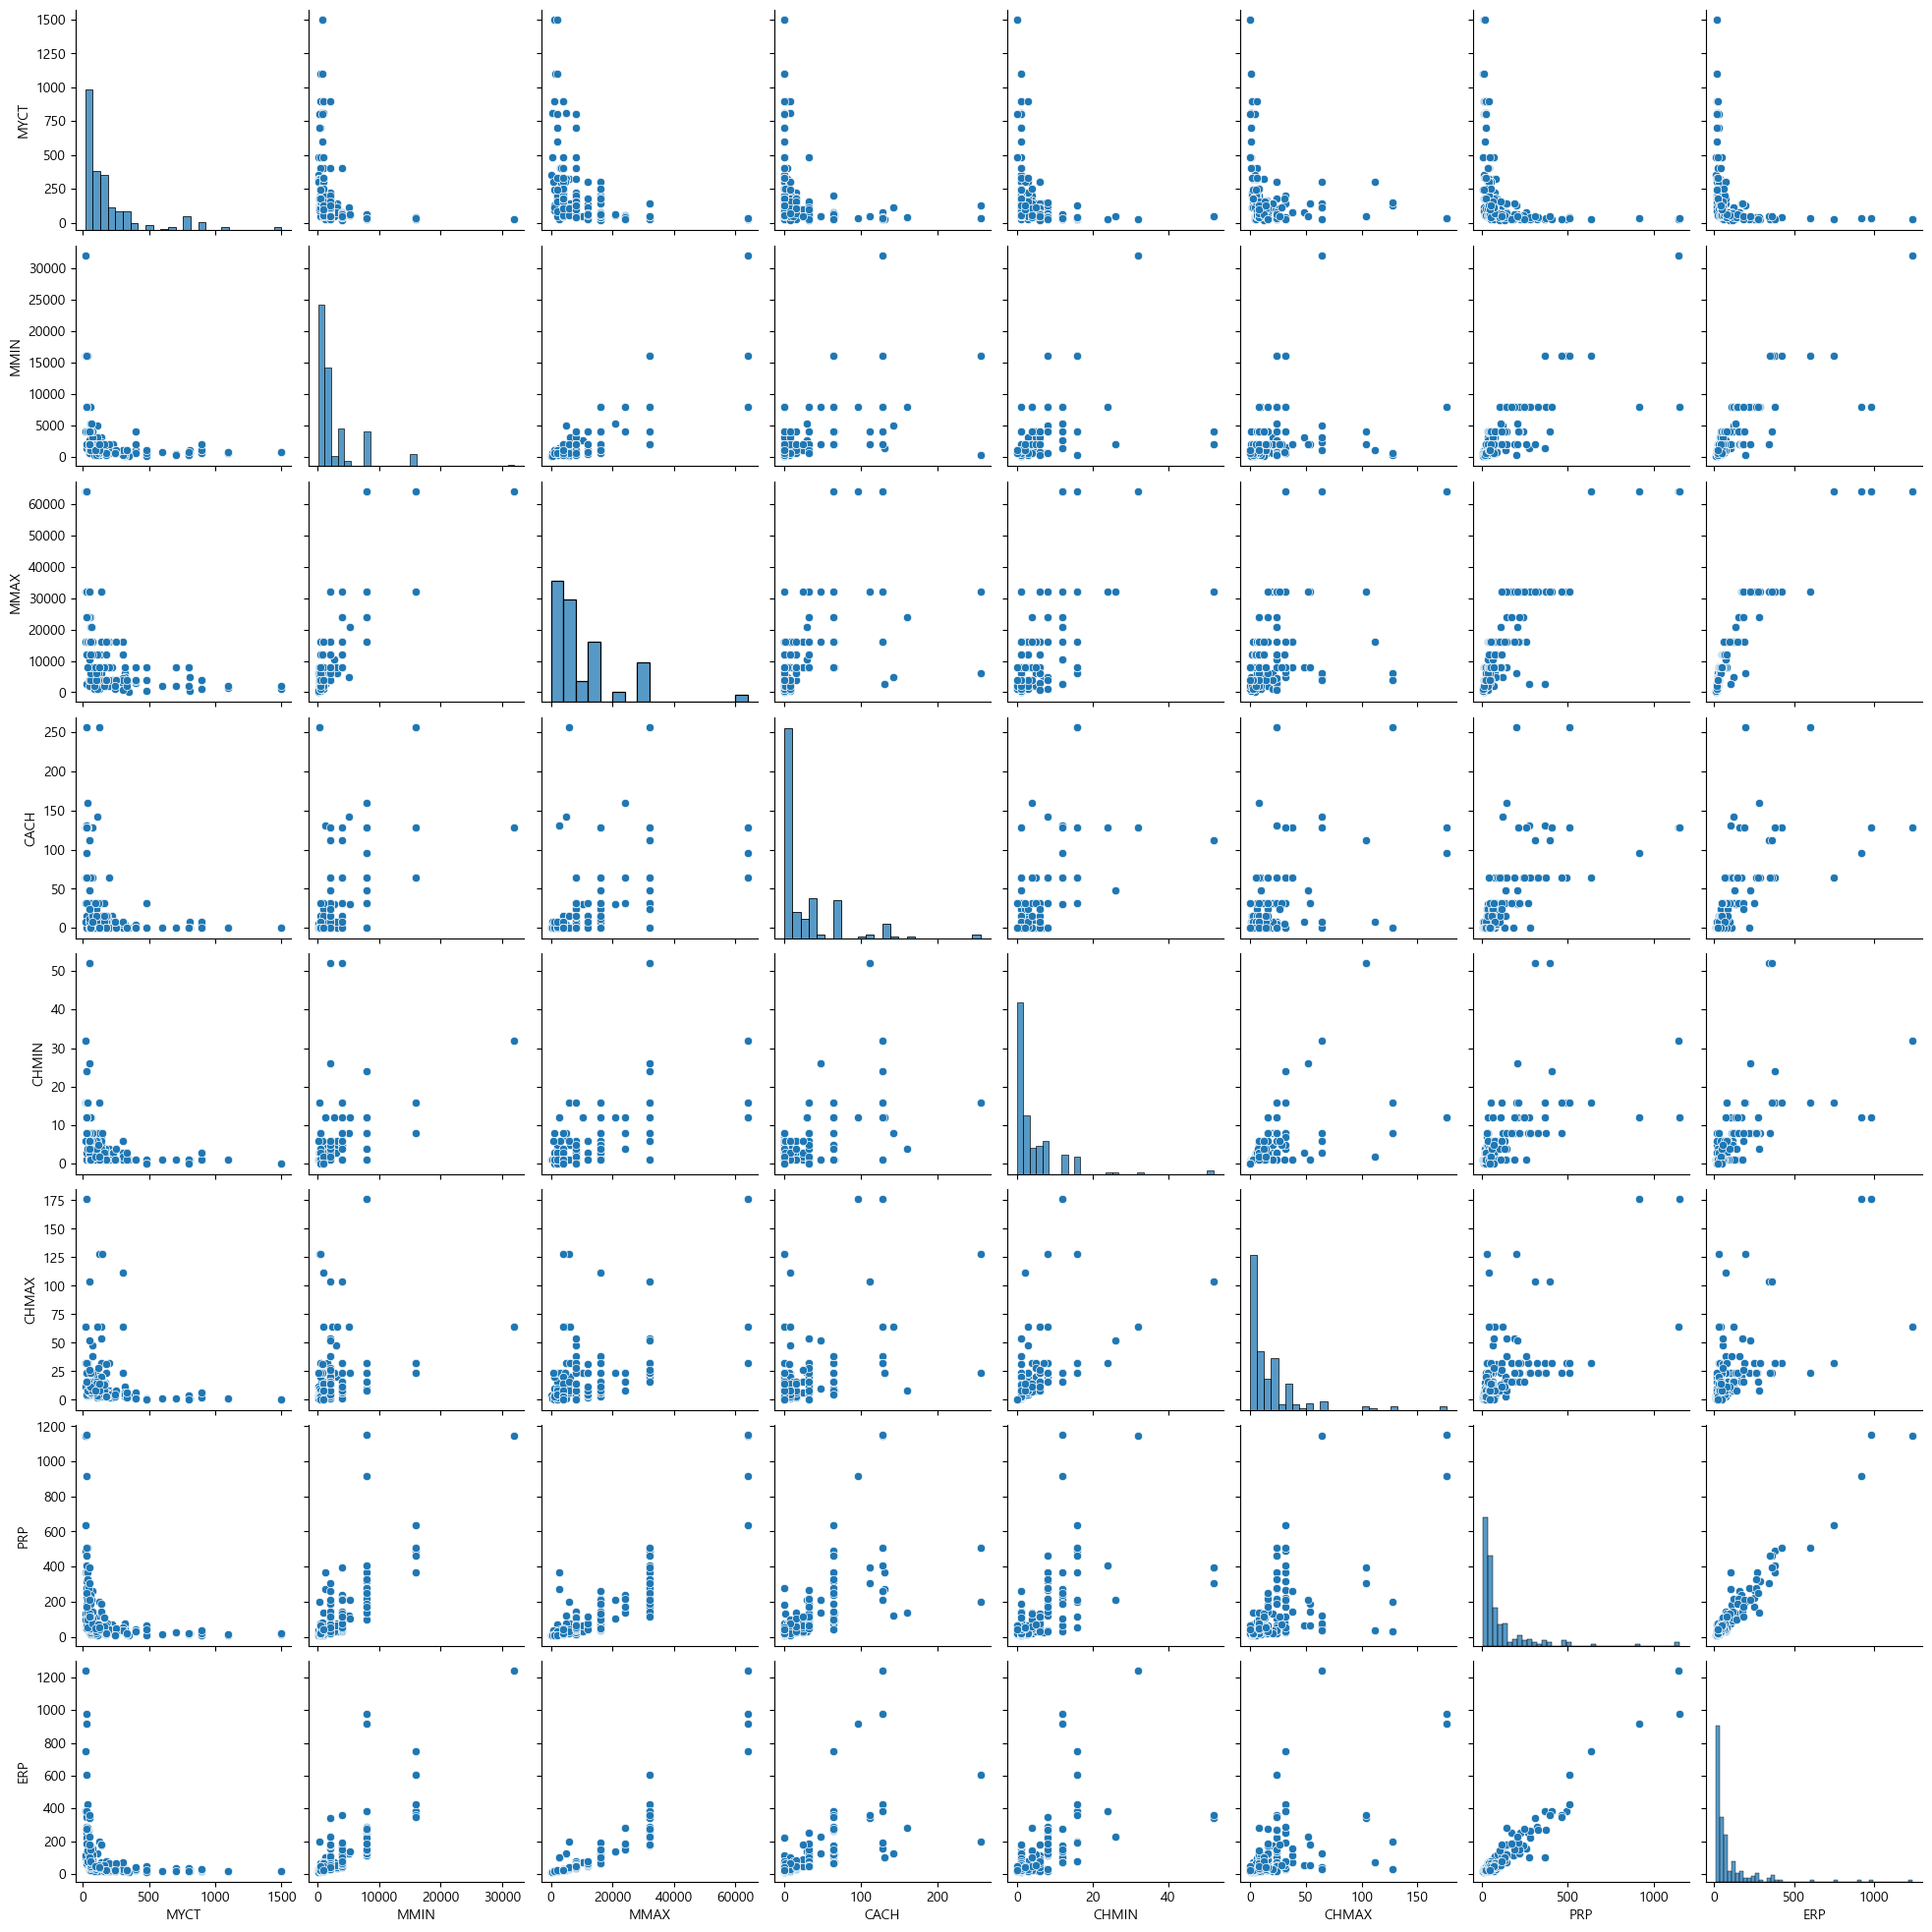

훈련 데이터 MSE: 809.6227465903561
훈련 데이터 MAE: 11.432959545195326
훈련 데이터 R^2: 0.957885780639549
테스트 데이터 MSE: 6856.618354447603
테스트 데이터 MAE: 34.399645880574454
테스트 데이터 R^2: 0.8653105048365416
최적 하이퍼파라미터: {'regressor__max_depth': None, 'regressor__n_estimators': 200}


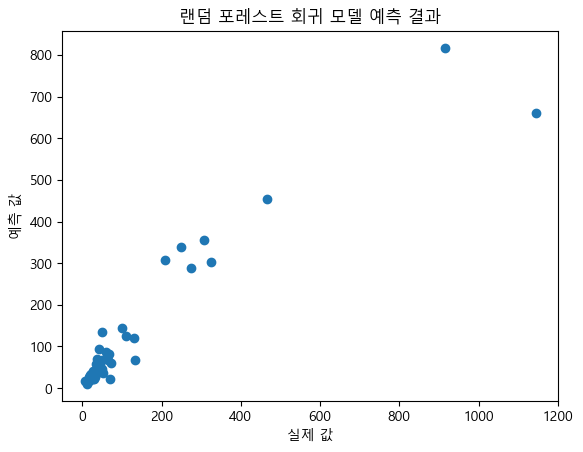

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.font_manager as fm
import matplotlib

# 한글 폰트 설정 (Windows의 경우 'Malgun Gothic'을 사용)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 파일 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
# 데이터 로드
df = pd.read_csv("machine_data_update.csv")  # 3차 과제에서 수정된 데이터 파일 사용

# 데이터 탐색 및 시각화
print(df.describe())  # 기술 통계량 출력
sns.pairplot(df)  # 변수 간 산점도 행렬 출력
plt.show()

# 특징 선택 (3차 과제에서 선택한 특징 사용)
selected_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
X = df[selected_features]
y = df['PRP']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline 생성 (전처리 + 모델)
pipe = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('regressor', RandomForestRegressor(random_state=42))  # 랜덤 포레스트 회귀 모델
])

# 하이퍼파라미터 튜닝
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적 모델
best_model = grid_search.best_estimator_

# 훈련 데이터 예측 및 평가
y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# 테스트 데이터 예측 및 평가
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 결과 출력
print("훈련 데이터 MSE:", mse_train)
print("훈련 데이터 MAE:", mae_train)
print("훈련 데이터 R^2:", r2_train)
print("테스트 데이터 MSE:", mse_test)
print("테스트 데이터 MAE:", mae_test)
print("테스트 데이터 R^2:", r2_test)
print("최적 하이퍼파라미터:", grid_search.best_params_)

# (Optional) 분석 결과 시각화
plt.scatter(y_test, y_test_pred)  # 실제 값 vs 예측 값 산점도
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.title("랜덤 포레스트 회귀 모델 예측 결과")
plt.show()


In [10]:
# (1) 단계에서 얻은 best_estimator 모델 가져오기 (grid_search에서)
best_model = grid_search.best_estimator_

# 훈련 데이터 예측 및 평가
y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# 교차 검증 (훈련 데이터) - 음의 MSE 사용
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_train = -cv_scores.mean()  # 음수 MSE를 양수로 변환

# 테스트 데이터 예측 및 평가
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 교차 검증 (테스트 데이터) - 음의 MSE 사용
cv_scores = cross_val_score(best_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
mse_cv_test = -cv_scores.mean()  # 음수 MSE를 양수로 변환

# 결과 출력
print("훈련 데이터 MSE:", mse_train)
print("훈련 데이터 MAE:", mae_train)
print("훈련 데이터 R^2:", r2_train)
print("훈련 데이터 교차 검증 MSE:", mse_cv_train)

print("테스트 데이터 MSE:", mse_test)
print("테스트 데이터 MAE:", mae_test)
print("테스트 데이터 R^2:", r2_test)
print("테스트 데이터 교차 검증 MSE:", mse_cv_test)


훈련 데이터 MSE: 809.6227465903561
훈련 데이터 MAE: 11.432959545195326
훈련 데이터 R^2: 0.957885780639549
훈련 데이터 교차 검증 MSE: 5397.056654475615
테스트 데이터 MSE: 6856.618354447603
테스트 데이터 MAE: 34.399645880574454
테스트 데이터 R^2: 0.8653105048365416
테스트 데이터 교차 검증 MSE: 30454.63137020833


In [12]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 하이퍼파라미터 탐색 공간 확장 및 RandomizedSearchCV 사용 (수정)
param_dist = {
    'regressor__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    'regressor__max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None] # 'auto' 제거
}

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)  # RandomizedSearchCV 훈련

# 최적 모델 업데이트
best_model = random_search.best_estimator_

# 테스트 데이터 예측 및 R^2 계산
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

while r2_test < 0.85:  # R^2 85% 이상이 될 때까지 반복
    random_search.fit(X_train, y_train)  # RandomizedSearchCV 재훈련
    best_model = random_search.best_estimator_
    y_test_pred = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)

# 결과 출력
print("개선된 모델의 테스트 데이터 R^2:", r2_test)
print("최적의 하이퍼파라미터:", random_search.best_params_)


개선된 모델의 테스트 데이터 R^2: 0.867449551508247
최적의 하이퍼파라미터: {'regressor__n_estimators': 800, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': None, 'regressor__max_depth': 60}


| Model             | Data             | MSE        | MAE      | R^2     |
|:------------------|:-----------------|:-----------|:---------|:--------|
| Linear Regression | Train            | 0.00000    | 0.00097  | 1.00000 |
| Linear Regression | Test             | 4516.67797 | 33.91143 | 0.92112 |
| Best_estimator    | Train            | 205.42673  | 8.24451  | 0.98140 |
| Best_estimator    | Test             | 7674.88548 | 40.11407 | 0.86597 |
| Linear Regression | Cross Validation | 1783.12357 | 24.04794 | 0.73001 |
| Best_estimator    | Cross Validation | 1708.67520 | 23.44605 | 0.76946 |


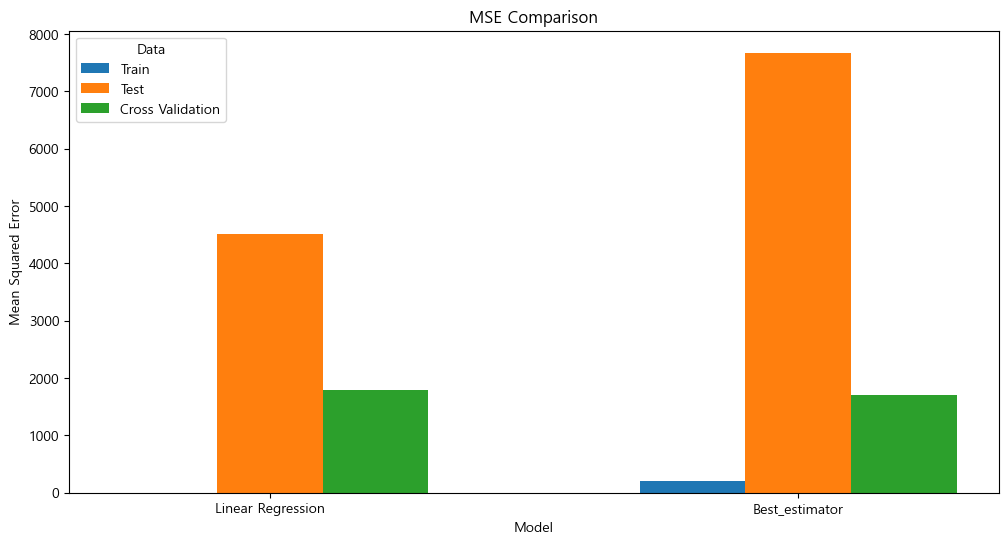

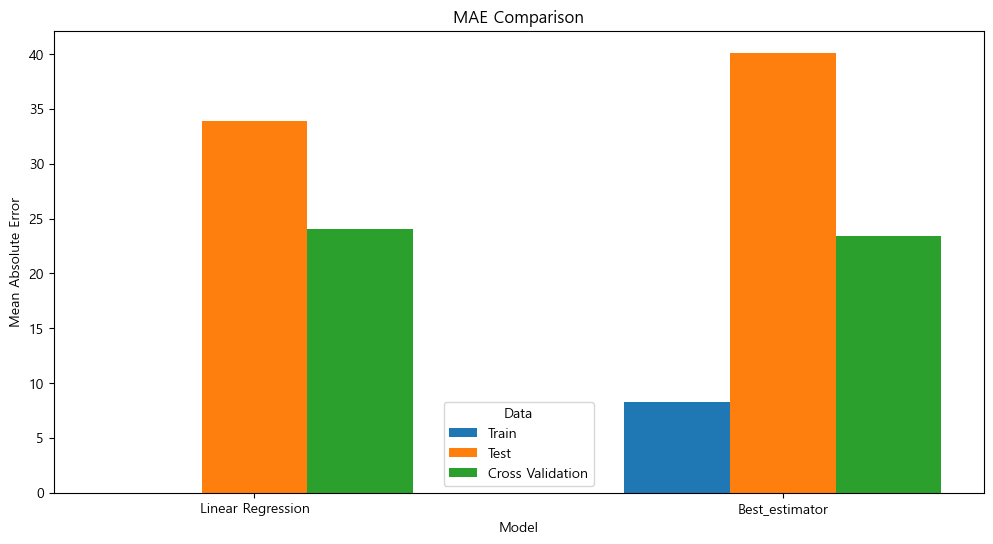

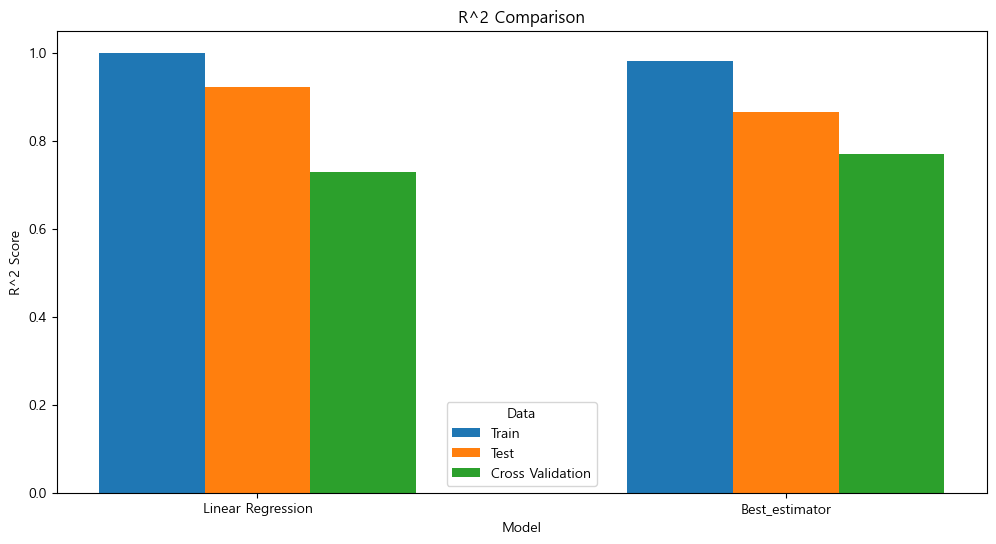

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 생성 (주어진 데이터 사용)
data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Linear Regression', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [0.000002, 4516.677970, 205.426726, 7674.885477, 1783.123574, 1708.675202],
    'MAE': [0.000970, 33.911430, 8.244508, 40.114066, 24.047939, 23.446047],
    'R^2': [1.000000, 0.921121, 0.981405, 0.865966, 0.730010, 0.769462]
}

df = pd.DataFrame(data)

# 전체 데이터 표 출력
print(df.to_markdown(index=False, numalign='left', stralign='left', floatfmt='.5f'))

# 시각화 함수 정의
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = range(len(df['Model'].unique()))
    for i, data_type in enumerate(df['Data'].unique()):
        filtered_df = df[df['Data'] == data_type]
        plt.bar([x + i * bar_width for x in index], filtered_df[metric], width=bar_width, label=data_type)
    plt.xlabel('Model')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([x + bar_width for x in index], df['Model'].unique())
    plt.legend(title='Data')
    plt.show()

# MSE, MAE, R^2 시각화
metrics = {'MSE': 'Mean Squared Error', 'MAE': 'Mean Absolute Error', 'R^2': 'R^2 Score'}
for metric, ylabel in metrics.items():
    plot_metric(metric, ylabel, f'{metric} Comparison')
